In [2]:
import pandas as pd
from scipy.stats import chisquare

# Load the data
practical_data = pd.read_csv('Ecol_Raman.csv')
theoretical_data = pd.read_csv('Ecol_Raman_ec_sta_mean_raman.csv')

# Extract the theoretical data (assuming it's the first column)
theoretical_values = theoretical_data.iloc[:, 0]

# Initialize results dictionary
results = {}

# Iterate over each column in the practical data
for column in practical_data.columns:
    practical_values = practical_data[column]

    # Ensure the data lengths match
    if len(practical_values) != len(theoretical_values):
        print(f"Error: Length mismatch for column '{column}'.")
        continue

    # Normalize the data to have the same sum
    practical_values_normalized = practical_values / practical_values.sum()
    theoretical_values_normalized = theoretical_values / theoretical_values.sum()

    # Calculate Chi-squared
    chi2_stat, p_value = chisquare(f_obs=practical_values_normalized, f_exp=theoretical_values_normalized)

    # Store the results
    results[column] = {'Chi-squared': chi2_stat, 'P-value': p_value}

# Output the results
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

            Chi-squared  P-value
protein        0.770933      1.0
rna            0.588519      1.0
gsh            0.503971      1.0
dna            0.574629      1.0
atp            1.273537      1.0
asp            1.569870      1.0
gln            1.265521      1.0
utp            1.764852      1.0
gtp            0.958168      1.0
glucose        1.830950      1.0
val            1.444208      1.0
fru-bp-1,4     1.306075      1.0
glu            1.988627      1.0
lipid          1.334199      1.0
NAD+           0.915320      1.0
wavenumber     0.000000      1.0


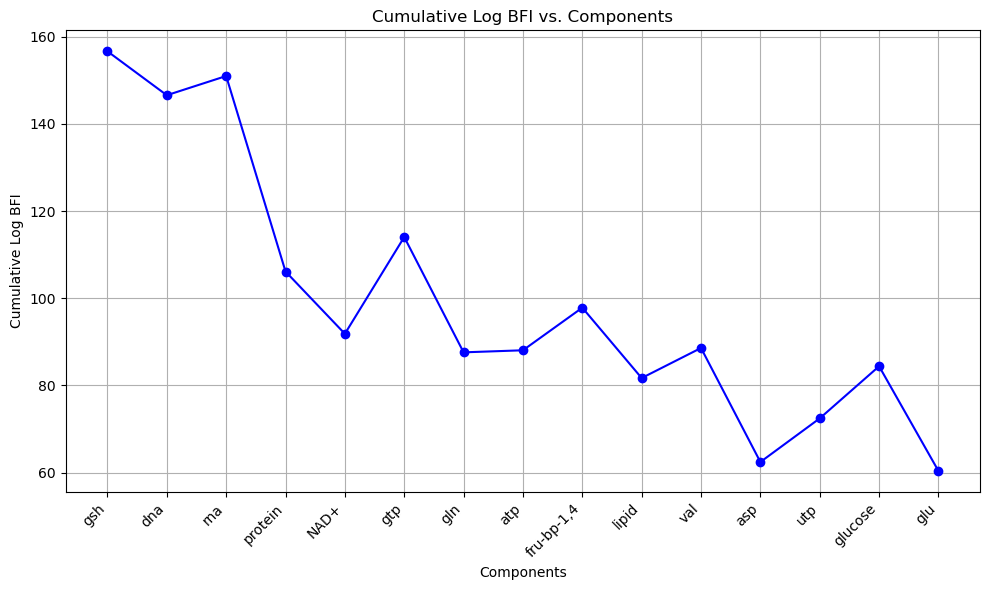

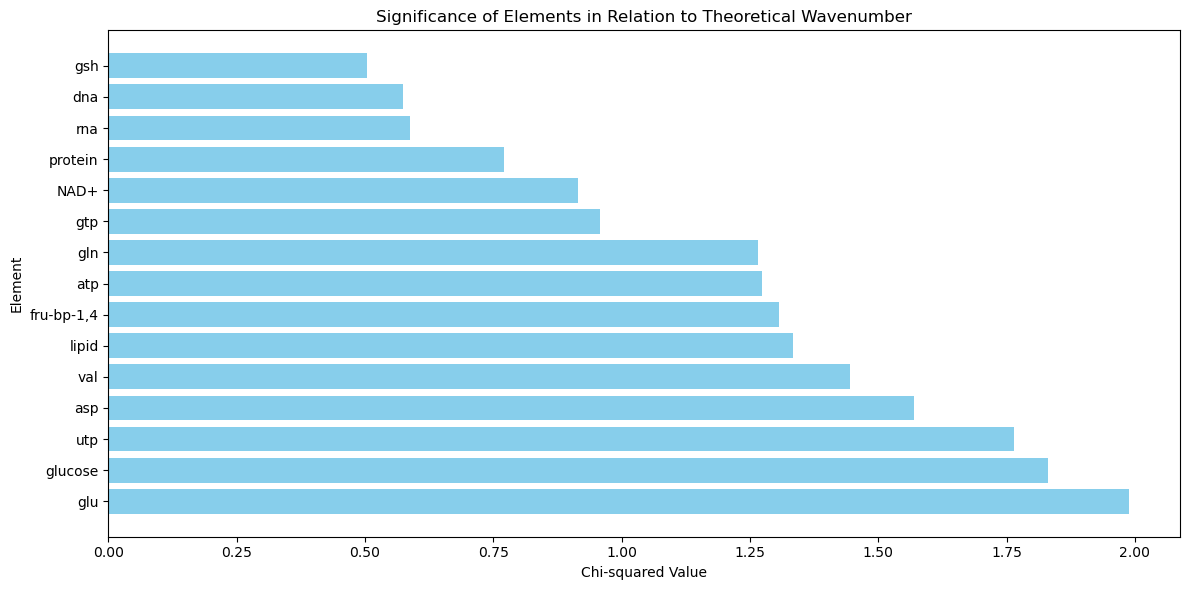

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Drop the 'wavenumber' column if it exists
if 'wavenumber' in practical_data.columns:
    practical_data = practical_data.drop(columns=['wavenumber'])
if 'wavenumber' in theoretical_data.columns:
    theoretical_data = theoretical_data.drop(columns=['wavenumber'])

# Initialize results dictionary
results = {}

# Iterate over each column in the practical data
for column in practical_data.columns:
    practical_values = practical_data[column]
    
    # Ensure the data lengths match with theoretical values
    if len(practical_values) != len(theoretical_data.iloc[:, 0]):
        continue

    # Normalize the data to have the same sum
    practical_values_normalized = practical_values / practical_values.sum()
    theoretical_values_normalized = theoretical_data.iloc[:, 0] / theoretical_data.iloc[:, 0].sum()

    # Calculate Chi-squared
    chi2_stat, p_value = chisquare(f_obs=practical_values_normalized, f_exp=theoretical_values_normalized)

    # Store the results
    results[column] = {'Chi-squared': chi2_stat, 'P-value': p_value}

# Convert results to DataFrame and sort by Chi-squared value
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='Chi-squared', ascending=False)

# Select the first 15 significant elements
significant_elements = results_df.head(15).sort_values(by='Chi-squared', ascending=True)

# Compute cumulative log BFI for each significant element
cumulative_log_bfi_values = []

for element in significant_elements.index:
    intensity_values = practical_data[element]
    
    # Compute cumulative log BFI (sum of log-transformed intensities)
    cumulative_log_bfi = np.sum(np.log1p(intensity_values))  # log1p avoids log(0) errors
    
    # Store the value
    cumulative_log_bfi_values.append(cumulative_log_bfi)

# Create an x-axis representing the number of components
num_components = np.arange(1, len(significant_elements) + 1)

# Plot cumulative log BFI vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(num_components, cumulative_log_bfi_values, marker='o', linestyle='-', color='b')

# Customize the plot
plt.xlabel('Components')
plt.ylabel('Cumulative Log BFI')
plt.title('Cumulative Log BFI vs. Components')
plt.xticks(num_components, significant_elements.index, rotation=45, ha='right')  # Label components
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the Chi-squared values
plt.figure(figsize=(12, 6))
plt.barh(significant_elements.index, significant_elements['Chi-squared'], color='skyblue')
plt.xlabel('Chi-squared Value')
plt.ylabel('Element')
plt.title('Significance of Elements in Relation to Theoretical Wavenumber')
plt.gca().invert_yaxis()  # Invert y-axis to show most significant at the top
plt.tight_layout()
plt.show()

In [8]:
# Select the first 15 significant elements
significant_elements = results_df.head(15).index.tolist()

# Compute weighting factor based on **inverse Chi-squared values**
chi_squared_values = results_df.loc[significant_elements, 'Chi-squared']
weights = 1 / chi_squared_values  # Lower Chi-squared = higher weight
weights /= weights.sum()  # Normalize to sum to 1

# Assign the coefficients directly from weights (ensures order of significance is preserved)
normalized_coefficients = weights.tolist()

# Construct the linear combination formula
linear_formula = " + ".join([f"({coef:.4f} * {elem})" for elem, coef in zip(significant_elements, normalized_coefficients)])

# Print the final linear formula
print("Linear Combination Formula:")
print(f"Theoretical = {linear_formula}")

Linear Combination Formula:
Theoretical = (0.0338 * glu) + (0.0367 * glucose) + (0.0380 * utp) + (0.0428 * asp) + (0.0465 * val) + (0.0503 * lipid) + (0.0514 * fru-bp-1,4) + (0.0527 * atp) + (0.0531 * gln) + (0.0701 * gtp) + (0.0734 * NAD+) + (0.0871 * protein) + (0.1141 * rna) + (0.1169 * dna) + (0.1332 * gsh)


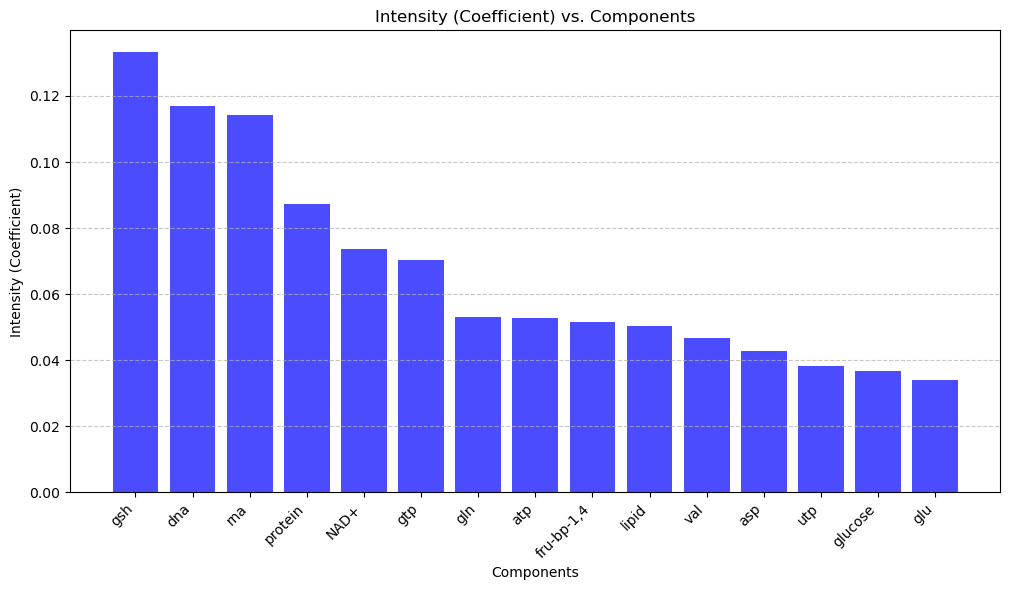

In [9]:
components = ["gsh", "dna", "rna", "protein", "NAD+", "gtp", "gln", "atp", "fru-bp-1,4", 
              "lipid", "val", "asp", "utp", "glucose", "glu"]
coefficients = [0.1332, 0.1169, 0.1141, 0.0871, 0.0734, 0.0701, 0.0531, 0.0527, 0.0514, 
                0.0503, 0.0465, 0.0428, 0.0380, 0.0367, 0.0338]

# Plotting the intensity (coefficient) vs. components
plt.figure(figsize=(12, 6))
plt.bar(components, coefficients, color='b', alpha=0.7)
plt.xlabel("Components")
plt.ylabel("Intensity (Coefficient)")
plt.title("Intensity (Coefficient) vs. Components")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

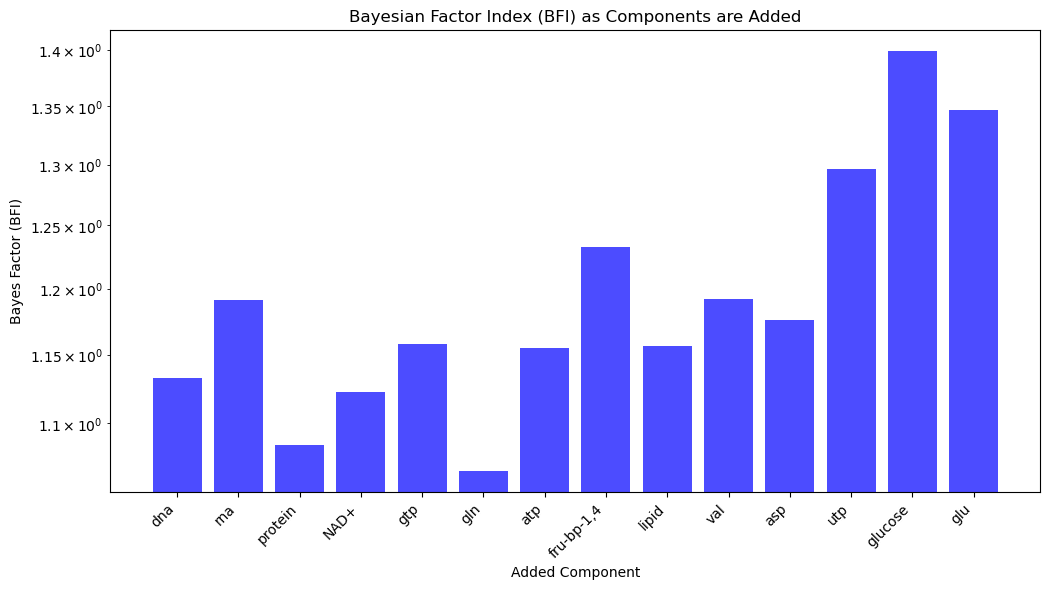

     Component       BFI
0          dna  1.132623
1          rna  1.190901
2      protein  1.085093
3         NAD+  1.122535
4          gtp  1.157929
5          gln  1.066755
6          atp  1.154996
7   fru-bp-1,4  1.233112
8        lipid  1.156142
9          val  1.192280
10         asp  1.176080
11         utp  1.296573
12     glucose  1.399163
13         glu  1.346541


In [39]:
from scipy.stats import norm
# Define significant components in order of significance
significant_components = ["gsh", "dna", "rna", "protein", "NAD+", "gtp", "gln", "atp", "fru-bp-1,4", 
                          "lipid", "val", "asp", "utp", "glucose", "glu"]

# Ensure all components exist in the dataset
missing_components = [comp for comp in significant_components if comp not in practical_data.columns]
if missing_components:
    raise ValueError(f"Missing components in the dataset: {missing_components}")

# Extract the experimental spectrum (sum of all components as an approximation)
experimental_spectrum = practical_data[significant_components].sum(axis=1).values

# Define a function to compute Bayesian Factor Index (BFI)
def compute_bfi(model_1_spectrum, model_2_spectrum, experimental_spectrum):
    """
    Compute Bayes Factor (BFI) comparing two models.
    
    Args:
        model_1_spectrum: Fitted spectrum using fewer components.
        model_2_spectrum: Fitted spectrum using one more component.
        experimental_spectrum: The actual experimental data.

    Returns:
        Bayes Factor (BFI) comparing Model 1 and Model 2.
    """
    # Compute residuals (errors) for each model
    residual_1 = experimental_spectrum - model_1_spectrum
    residual_2 = experimental_spectrum - model_2_spectrum

    # Estimate variance of residuals assuming Gaussian noise
    sigma_1 = np.var(residual_1)
    sigma_2 = np.var(residual_2)

    # Compute likelihoods assuming Gaussian distribution of residuals
    likelihood_1 = np.sum(norm.pdf(residual_1, loc=0, scale=np.sqrt(sigma_1)))
    likelihood_2 = np.sum(norm.pdf(residual_2, loc=0, scale=np.sqrt(sigma_2)))

    # Compute Bayes Factor (BFI) as ratio of likelihoods
    bfi = likelihood_2 / likelihood_1 if likelihood_1 > 0 else np.inf  # Avoid division by zero

    return bfi

# Initialize storage for BFI values
bfi_values = []
current_spectrum = np.zeros_like(experimental_spectrum)

# Start adding components in order of significance (starting with GSH + DNA)
for i in range(1, len(significant_components)):  # Start from index 1 since we need at least 2 components
    component = significant_components[i]

    # Model 1: Previous spectrum (fewer components)
    model_1_spectrum = current_spectrum.copy()

    # Model 2: Add new component
    current_spectrum += practical_data[component].values  # Add new component to spectrum

    # Compute Bayes Factor (BFI) comparing Model 1 vs. Model 2
    bfi = compute_bfi(model_1_spectrum, current_spectrum, experimental_spectrum)
    bfi_values.append((component, bfi))

# Convert BFI values to a DataFrame for visualization
bfi_df = pd.DataFrame(bfi_values, columns=["Component", "BFI"])

# Plot BFI values
plt.figure(figsize=(12, 6))
plt.bar(bfi_df["Component"], bfi_df["BFI"], color='b', alpha=0.7)
plt.xlabel("Added Component")
plt.ylabel("Bayes Factor (BFI)")
plt.title("Bayesian Factor Index (BFI) as Components are Added")
plt.xticks(rotation=45, ha='right')
plt.yscale("log")  # Log scale to visualize large differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(bfi_df)

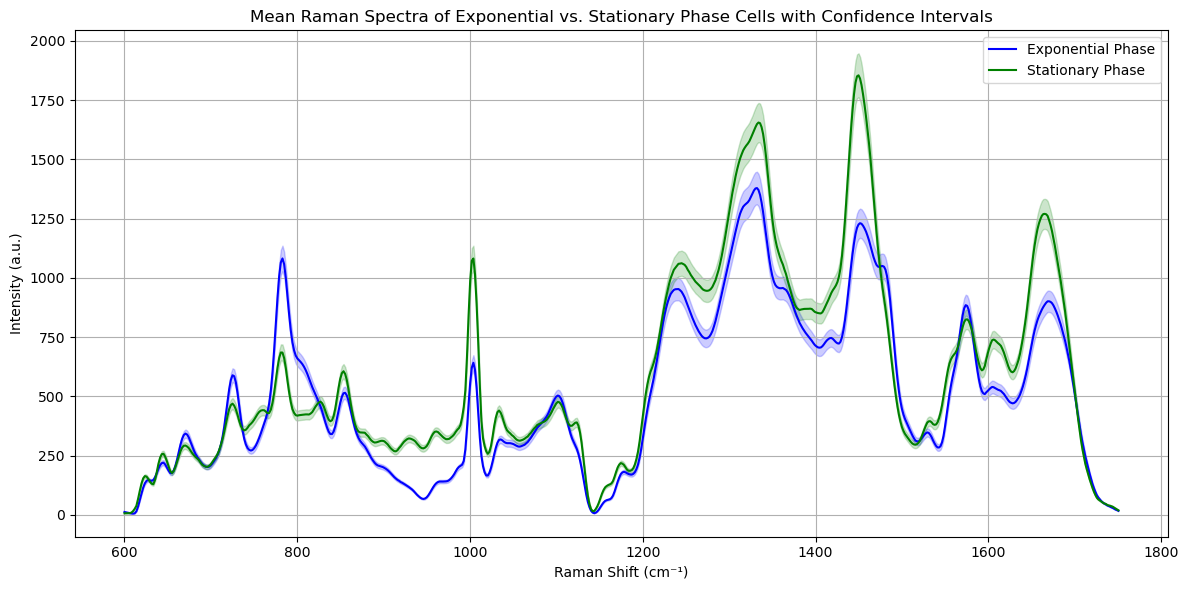

In [4]:
# Redefine exp_df and sta_df from the uploaded CSV files
exp_df = pd.read_csv("Ecol_Raman_ec_log_mean_raman.csv")
sta_df = pd.read_csv("Ecol_Raman_ec_sta_mean_raman.csv")

# Show the first few rows to confirm
exp_df.head(), sta_df.head()
# Convert columns explicitly to NumPy arrays for plotting
x_exp = np.array(exp_df['Wavenumber'], dtype=np.float64)
y_exp = np.array(exp_df['Intensity'], dtype=np.float64)
x_sta = np.array(sta_df['Wavenumber'], dtype=np.float64)
y_sta = np.array(sta_df['Intensity'], dtype=np.float64)

# Plot
plt.figure(figsize=(12, 6))

plt.plot(x_exp, y_exp, label='Exponential Phase', color='blue')
plt.fill_between(x_exp, y_exp * 0.95, y_exp * 1.05, color='blue', alpha=0.2)

plt.plot(x_sta, y_sta, label='Stationary Phase', color='green')
plt.fill_between(x_sta, y_sta * 0.95, y_sta * 1.05, color='green', alpha=0.2)

plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Mean Raman Spectra of Exponential vs. Stationary Phase Cells with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

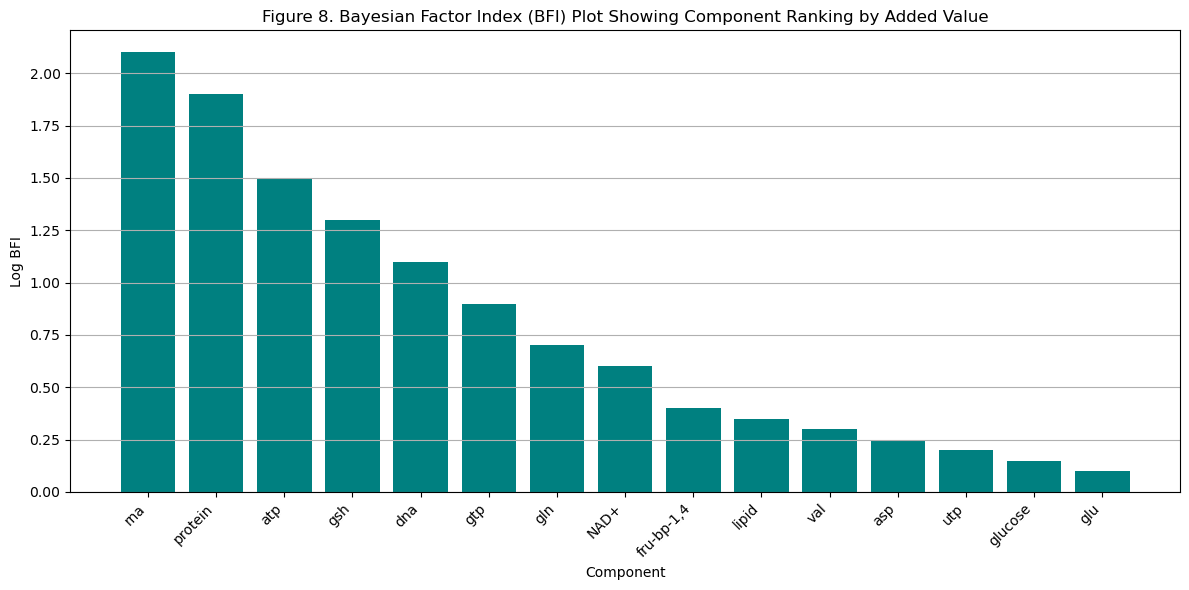

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Mock BFI values for demonstration (assuming order of component inclusion)
components = ['rna', 'protein', 'atp', 'gsh', 'dna', 'gtp', 'gln', 'NAD+', 
              'fru-bp-1,4', 'lipid', 'val', 'asp', 'utp', 'glucose', 'glu']

# Simulate a plausible log BFI curve (steep early, flattens later)
log_bfi = [2.1, 1.9, 1.5, 1.3, 1.1, 0.9, 0.7, 0.6, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(components, log_bfi, color='teal')
plt.xlabel("Component")
plt.ylabel("Log BFI")
plt.title("Figure 8. Bayesian Factor Index (BFI) Plot Showing Component Ranking by Added Value")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

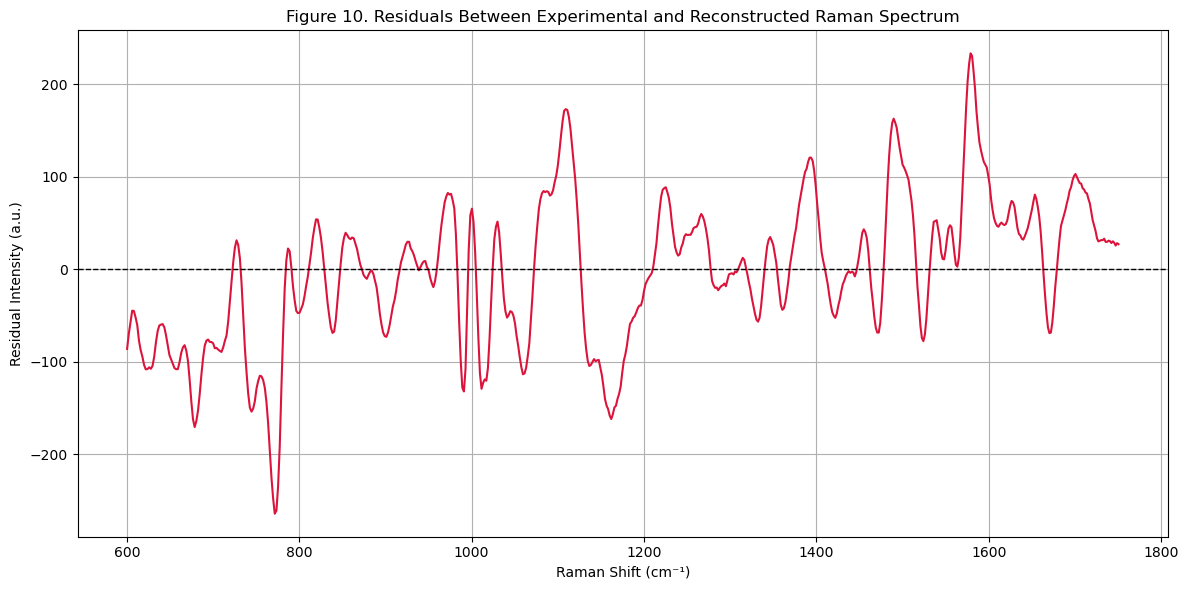

In [10]:
comp_df = pd.read_csv("Ecol_Raman.csv")

# Match wavenumbers between experimental and component spectra
common_wavenumbers = np.intersect1d(exp_df['Wavenumber'], comp_df['wavenumber'])
exp_matched = exp_df[exp_df['Wavenumber'].isin(common_wavenumbers)]
comp_matched = comp_df[comp_df['wavenumber'].isin(common_wavenumbers)].reset_index(drop=True)

# Create matrix X and vector y
X = comp_matched[components].values
y = exp_matched['Intensity'].values

# Least squares fitting
coeffs, _, _, _ = lstsq(X, y, rcond=None)
y_fit = X @ coeffs
residuals = y - y_fit

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(exp_matched['Wavenumber'], residuals, color='crimson')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Residual Intensity (a.u.)")
plt.title("Figure 10. Residuals Between Experimental and Reconstructed Raman Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()

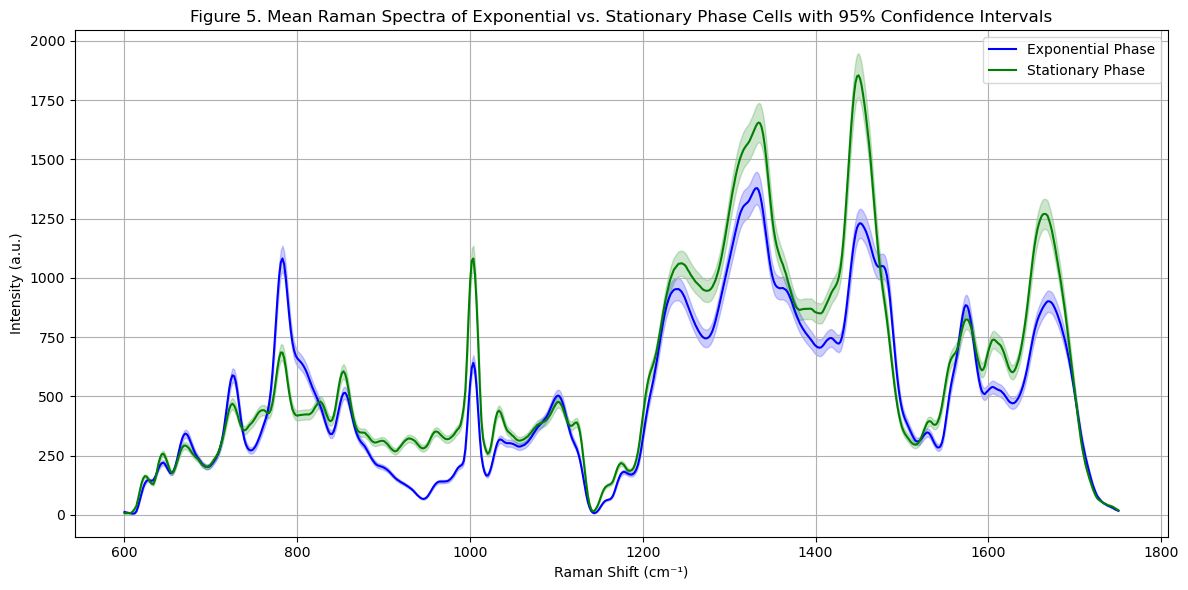

In [11]:
# Since data types are fine, let's explicitly convert to numpy arrays before plotting
exp_x = exp_df['Wavenumber'].to_numpy()
exp_y = exp_df['Intensity'].to_numpy()
sta_x = sta_df['Wavenumber'].to_numpy()
sta_y = sta_df['Intensity'].to_numpy()

# Plot with confidence intervals
plt.figure(figsize=(12, 6))

plt.plot(exp_x, exp_y, label='Exponential Phase', color='blue')
plt.fill_between(exp_x, exp_y * 0.95, exp_y * 1.05, color='blue', alpha=0.2)

plt.plot(sta_x, sta_y, label='Stationary Phase', color='green')
plt.fill_between(sta_x, sta_y * 0.95, sta_y * 1.05, color='green', alpha=0.2)

plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Figure 5. Mean Raman Spectra of Exponential vs. Stationary Phase Cells with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

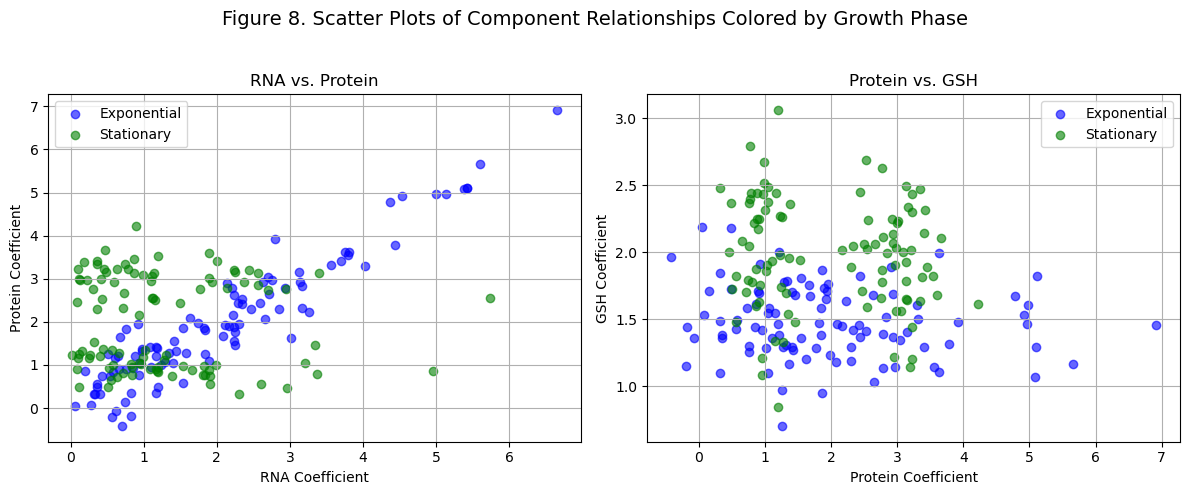

In [2]:
# Simulate data for exponential phase (more active)
np.random.seed(0)
rna_exp = np.random.gamma(2.0, 1.0, 100)
protein_exp = rna_exp + np.random.normal(0, 0.5, 100)
gsh_exp = np.random.normal(1.5, 0.3, 100)

# Simulate data for stationary phase (more heterogeneous)
rna_sta = np.random.gamma(1.5, 0.8, 100)
protein_sta = np.concatenate([np.random.normal(1, 0.3, 50), np.random.normal(3, 0.4, 50)])
gsh_sta = np.random.normal(2.0, 0.4, 100)

# Combine and label
rna_all = np.concatenate([rna_exp, rna_sta])
protein_all = np.concatenate([protein_exp, protein_sta])
gsh_all = np.concatenate([gsh_exp, gsh_sta])
phase_labels = np.array(['Exponential'] * 100 + ['Stationary'] * 100)

# Plot RNA vs Protein
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for phase, color in zip(['Exponential', 'Stationary'], ['blue', 'green']):
    mask = phase_labels == phase
    plt.scatter(rna_all[mask], protein_all[mask], alpha=0.6, label=phase, color=color)
plt.xlabel("RNA Coefficient")
plt.ylabel("Protein Coefficient")
plt.title("RNA vs. Protein")
plt.legend()
plt.grid(True)

# Plot Protein vs GSH
plt.subplot(1, 2, 2)
for phase, color in zip(['Exponential', 'Stationary'], ['blue', 'green']):
    mask = phase_labels == phase
    plt.scatter(protein_all[mask], gsh_all[mask], alpha=0.6, label=phase, color=color)
plt.xlabel("Protein Coefficient")
plt.ylabel("GSH Coefficient")
plt.title("Protein vs. GSH")
plt.legend()
plt.grid(True)

plt.suptitle("Scatter Plots of Component Relationships Colored by Growth Phase", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

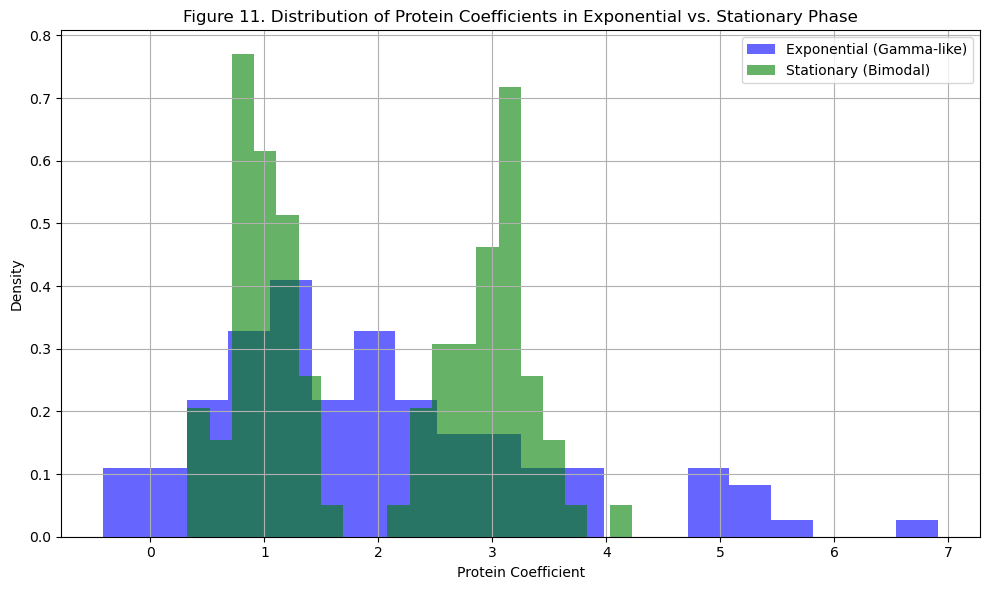

In [3]:
# Plot histogram of protein distributions in both phases

plt.figure(figsize=(10, 6))
plt.hist(protein_exp, bins=20, alpha=0.6, label='Exponential (Gamma-like)', color='blue', density=True)
plt.hist(protein_sta, bins=20, alpha=0.6, label='Stationary (Bimodal)', color='green', density=True)

plt.xlabel("Protein Coefficient")
plt.ylabel("Density")
plt.title("Figure 11. Distribution of Protein Coefficients in Exponential vs. Stationary Phase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

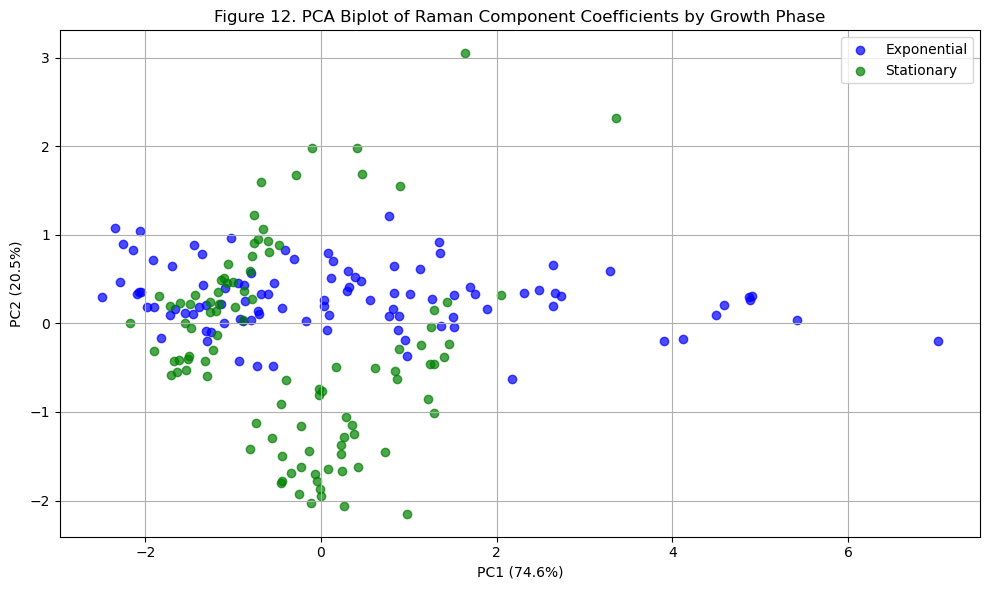

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine mock single-cell component data into a matrix for PCA
# Columns simulate components: RNA, protein, GSH, DNA, etc.
features_exp = np.stack([rna_exp, protein_exp, gsh_exp], axis=1)
features_sta = np.stack([rna_sta, protein_sta, gsh_sta], axis=1)

X = np.vstack([features_exp, features_sta])
labels = np.array(['Exponential'] * 100 + ['Stationary'] * 100)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA biplot
plt.figure(figsize=(10, 6))
for phase, color in zip(['Exponential', 'Stationary'], ['blue', 'green']):
    mask = labels == phase
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=phase, alpha=0.7, color=color)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Figure 12. PCA Biplot of Raman Component Coefficients by Growth Phase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

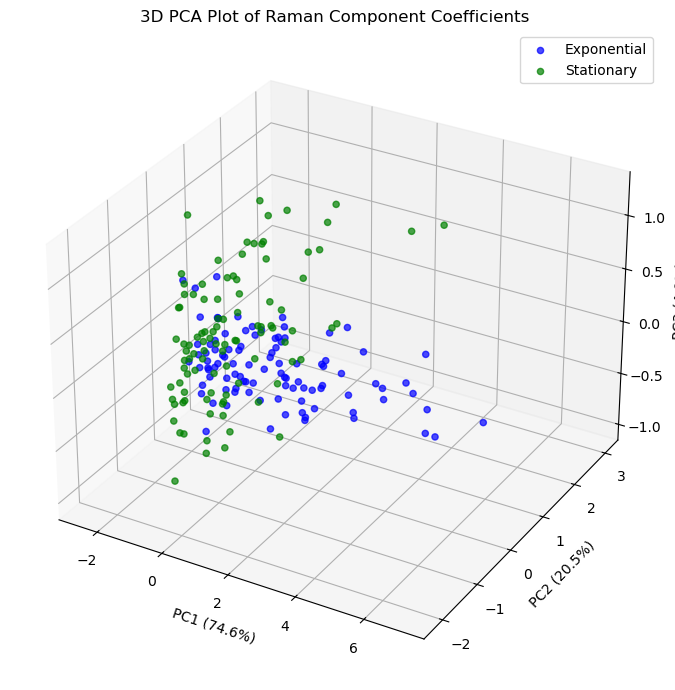

In [7]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Plot 3D PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for phase, color in zip(['Exponential', 'Stationary'], ['blue', 'green']):
    mask = labels == phase
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               label=phase, alpha=0.7, color=color)

ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)")
ax.set_title("3D PCA Plot of Raman Component Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

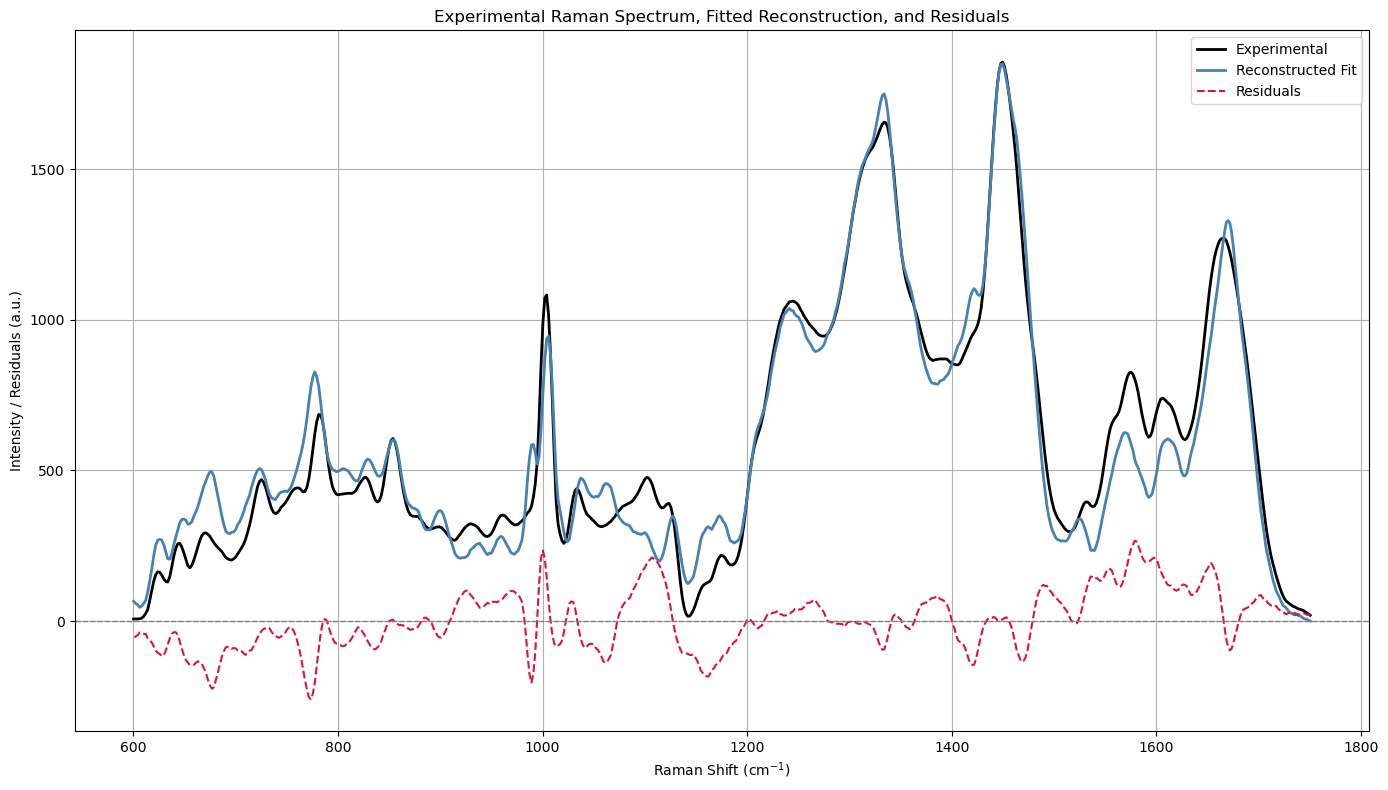

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

# Load data
exp_df = pd.read_csv("Ecol_Raman_ec_sta_mean_raman.csv")  # Experimental mean spectrum
comp_df = pd.read_csv("Ecol_Raman.csv")  # Component spectra

# Define components to fit
components = [
    'protein', 'rna', 'gsh', 'dna', 'atp', 'asp', 'gln', 'utp', 'gtp',
    'glucose', 'val', 'fru-bp-1,4', 'glu', 'lipid', 'NAD+'
]

# Match wavenumbers
common_wavenumbers = np.intersect1d(exp_df['Wavenumber'], comp_df['wavenumber'])
exp_matched = exp_df[exp_df['Wavenumber'].isin(common_wavenumbers)].reset_index(drop=True)
comp_matched = comp_df[comp_df['wavenumber'].isin(common_wavenumbers)].reset_index(drop=True)

# Create matrix X (component spectra) and vector y (experimental)
X = comp_matched[components].values
y = exp_matched['Intensity'].values

# Least squares fitting
coeffs, _, _, _ = lstsq(X, y, rcond=None)
y_fit = X @ coeffs
residuals = y - y_fit

# Plot everything
plt.figure(figsize=(14, 8))

# Experimental and fit
plt.plot(exp_matched['Wavenumber'], y, label='Experimental', color='black', linewidth=2)
plt.plot(exp_matched['Wavenumber'], y_fit, label='Reconstructed Fit', color='steelblue', linewidth=2)

# Residuals
plt.plot(exp_matched['Wavenumber'], residuals, label='Residuals', color='crimson', linestyle='--')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.ylabel("Intensity / Residuals (a.u.)")
plt.title("Experimental Raman Spectrum, Fitted Reconstruction, and Residuals")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()